In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Parámetros
profit = 0  # Initialize profit at the beginning of each day
initial_lost = - 500  # Stop Loss Threshold
new_stop_level = 400
second_stop_level = 600
n = 10  # Número de velas anteriores a considerar
r = 1000   # Rango máximo admitido antes de 
first_target = 1000  # When price gets first target profit,move stop to break even
second_target = 1500

In [3]:
# Definir la ruta del archivo
file_path = os.path.join("Output", "ES_data_5_min_2024_2025.csv")

# Cargar el archivo CSV
df = pd.read_csv(file_path)
summary_df = pd.DataFrame(columns=["date", "profit", "min_profit", "max_profit"])
summary_df = summary_df.round(2)
print("File loaded successfully!")

File loaded successfully!


In [4]:
# Convertir 'date' a formato datetime con UTC
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# Eliminar la zona horaria y ajustar a minutos
df['date'] = df['date'].dt.tz_localize(None).dt.floor('min')

In [5]:
df['fecha'] = df['date'].dt.date  # Extract only the date part (ignore time)

# Create a mask to rows where the date is the same as the previous row
df['same_day'] = df['fecha'] == df['fecha'].shift(1)

# Apply rolling calculation only when the current row belongs to the same date as the previous row
df['min_last_n'] = df['low'].where(df['same_day']).rolling(window=n, min_periods=n).min().shift(1)
df['max_last_n'] = df['high'].where(df['same_day']).rolling(window=n, min_periods=n).max().shift(1)
df['rango'] = abs(df['max_last_n']-df['min_last_n'])

# Drop helper column
#df.drop(columns=['same_day'], inplace=True)

# Calcular el máximo y mínimo de las últimas `n` velas

#df['min_last_n'] = df['low'].rolling(window=n).min().shift(1)   # Mínimo de las últimas `n` velas
#df['max_last_n'] = df['high'].rolling(window=n).max().shift(1)  # Máximo de las últimas `n` velas

# Definir la señal cuando el cierre rompe el rango de las últimas `n` velas
#df['senyal'] = (df['close'] > df['max_last_n']) | (df['close'] < df['min_last_n'])
df['senyal'] = ((df['close'] > df['max_last_n']) | (df['close'] < df['min_last_n'])) & (df['rango'] < r)

# No toma en cuenta ninguna senyal de entrda cuando se evalua la primera fila del dia
df.loc[~df['same_day'], 'senyal'] = False
df['profit'] = 0
df['stop'] = initial_lost

In [6]:
# Extraer la fecha sin la hora
df['day'] = df['date'].dt.date

# Inicializar wakeup
df['wakeup'] = False

# Variable para rastrear wakeup
wakeup_active = False
previous_day = None

for i, row in df.iterrows():
    current_day = row['day']

    # Reiniciar wakeup al inicio de un nuevo día
    if current_day != previous_day:
        wakeup_active = False  

    # Marcar wakeup solo si hay una señal de entrada y aún no se ha activado en el día
    if row['senyal'] and not wakeup_active:
        df.at[i, 'wakeup'] = True
        wakeup_active = True  

    previous_day = current_day  

# Eliminar la columna auxiliar 'day'
df.drop(columns=["day","volume", "average"], inplace=True)
df['bias'] = np.where(df['close'] > df['open'], 'Long', 'Short')
df.head(5)

,date,open,high,low,close,barCount,fecha,same_day,min_last_n,max_last_n,rango,senyal,profit,stop,wakeup,bias
0,2022-12-29 14:30:00,3805.45,3816.61,3805.45,3814.90,291,2022-12-29,False,NaN,NaN,NaN,False,0,-500,False,Long
1,2022-12-29 14:35:00,3814.70,3823.41,3814.05,3821.87,289,2022-12-29,True,NaN,NaN,NaN,False,0,-500,False,Long
2,2022-12-29 14:40:00,3821.97,3830.42,3821.97,3826.48,289,2022-12-29,True,NaN,NaN,NaN,False,0,-500,False,Long
3,2022-12-29 14:45:00,3826.44,3830.10,3826.24,3829.60,288,2022-12-29,True,NaN,NaN,NaN,False,0,-500,False,Long
4,2022-12-29 14:50:00,3829.58,3831.46,3824.31,3828.59,284,2022-12-29,True,NaN,NaN,NaN,False,0,-500,False,Short


In [7]:
def get_last_index_for_date(df, fecha_col, target_date):
    """
    Returns the index number where the next row's value in the specified 'fecha' column 
    is different from the current row for a given target date.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    fecha_col (str): The column name representing the date.
    target_date (str or datetime): The specific date to filter.

    Returns:
    int or None: The index number where the date changes, or None if no such index exists.
    """
    # Ensure fecha column is in datetime format
    df[fecha_col] = pd.to_datetime(df[fecha_col])

    # Ensure target_date is a datetime object (if given as string)
    target_date = pd.to_datetime(target_date).date()

    # Filter DataFrame to only include rows for the target date
    df_filtered = df[df[fecha_col].dt.date == target_date]

    # If no rows match the target date, return None
    if df_filtered.empty:
        print(f"No data found for {target_date}")
        return None

    # Get the last index for the target date
    last_index = df_filtered.index[-1]

    #print(f"Last index for {target_date} where '{fecha_col}' changes: {last_index}")
    return last_index

In [8]:
# Initialize variables
entry_price = None
entry_bias = None
profit_values = []
stop_values = []  # List to track stop loss values per row
previous_day = None

# Set the initial stop-loss value before iteration
lost = initial_lost  

# Iterate over each row in the DataFrame
for i, row in df.iterrows():
    current_day = row['date'].date()  # Ensure 'date' is in datetime format

    # Reset profit and entry at the start of a new day
    if previous_day is not None and current_day != previous_day:
        profit = 0
        entry_price = None
        entry_bias = None
        lost = initial_lost  # Reset stop-loss at the beginning of each day

    # Set entry price and bias if conditions are met
    if row['senyal'] and row['wakeup']:
        entry_price = row['close']
        entry_bias = row['bias']
        lost = initial_lost  # Reset stop-loss when a new entry occurs

    # Calculate profit based on trade direction
    if entry_price is not None:
        if entry_bias == "Long":
            profit = (row['close'] - entry_price) * 50
        elif entry_bias == "Short":
            profit = (entry_price - row['close']) * 50
        else:
            profit = 0

        # ✅ Move stop loss to new level **only if profit exceeds first_target**
        if profit > first_target:
            lost = new_stop_level  # Move stop loss to new level
            
        # ✅ Move stop loss to new level **only if profit exceeds first_target**
        if profit > second_target:
            lost = second_stop_level  # Move stop loss to new level

        # ✅ Apply Stop Loss: If profit falls below 'lost', exit trade
        if profit <= lost:
            profit = lost  # Register the stop loss hit
            entry_price = None  # Exit trade
            entry_bias = None  # Reset trade bias

    # Store profit and stop-loss values per row
    profit_values.append(profit)
    stop_values.append(lost)  # Store the stop level for each row

    # Update previous day tracker
    previous_day = current_day

# Convert lists to Pandas Series and assign to DataFrame
df['profit'] = pd.Series(profit_values, index=df.index)
df['stop'] = pd.Series(stop_values, index=df.index)  # Store dynamic stop-loss values


In [9]:
df = df.drop(columns=['barCount'])
df.head(8)

,date,open,high,low,close,fecha,same_day,min_last_n,max_last_n,rango,senyal,profit,stop,wakeup,bias
0,2022-12-29 14:30:00,3805.45,3816.61,3805.45,3814.90,2022-12-29,False,NaN,NaN,NaN,False,0.0,-500,False,Long
1,2022-12-29 14:35:00,3814.70,3823.41,3814.05,3821.87,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Long
2,2022-12-29 14:40:00,3821.97,3830.42,3821.97,3826.48,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Long
3,2022-12-29 14:45:00,3826.44,3830.10,3826.24,3829.60,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Long
4,2022-12-29 14:50:00,3829.58,3831.46,3824.31,3828.59,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Short
5,2022-12-29 14:55:00,3828.74,3832.92,3828.71,3830.84,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Long
6,2022-12-29 15:00:00,3830.82,3834.89,3829.16,3830.74,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Short
7,2022-12-29 15:05:00,3830.72,3837.56,3829.89,3835.62,2022-12-29,True,NaN,NaN,NaN,False,0.0,-500,False,Long


In [10]:
def plot_wakeup_signals(df, target_date, summary_df=None, save_folder="Chart"):
    """
    Generates a plot for wakeup signals, calculates the profit, and appends the result to summary_df.

    Parameters:
    df (pd.DataFrame): Market data DataFrame.
    target_date (str): Date in 'YYYY-MM-DD' format to analyze.
    summary_df (pd.DataFrame, optional): DataFrame to store the daily profit sum.
    save_folder (str): Folder where the chart image will be saved.

    Returns:
    str: Path to the saved image.
    pd.DataFrame: Updated summary_df with profit data, min profit, and max profit.
    """
    os.makedirs(save_folder, exist_ok=True)

    # Filter data for the specified date within the trading hours
    df_day = df[(df['date'] >= f'{target_date} 14:00') & (df['date'] < f'{target_date} 22:00')].copy()

    # If no data exists for this date, return None
    if df_day.empty:
        print(f"No data available for {target_date}.")
        return None, summary_df

    df_wakeup = df_day[df_day['wakeup']]  # Get wakeup signals

    # Calculate the total profit for the day
    daily_profit = df_day["profit"].sum()

    # Get the last index and its corresponding profit
    last_index = get_last_index_for_date(df, "fecha", target_date)
    if last_index is not None and last_index in df.index:
        profit_value = df.at[last_index, "profit"]
        plot_stop_value = df.at[last_index, "stop"]
        #print(f"The stop value at index {last_index} is: {plot_stop_value}")
        #formatted_profit = f"{profit_value:,.2f}"
        formatted_profit = profit_value
    else:
        print(f"No valid profit data for {target_date}.")
        return None, summary_df

    # Calculate the min and max profit for the day
    min_profit = df_day["profit"].min()
    max_profit = df_day["profit"].max()

    #formatted_min_profit = f"{min_profit:.2f}"
    #formatted_max_profit = f"{max_profit:.2f}"
    formatted_min_profit = min_profit
    formatted_max_profit = max_profit
    
    # Ensure summary_df is initialized and append the new row with additional min/max columns
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["date", "profit", "min_profit", "max_profit"])

    new_row = pd.DataFrame({
        "date": [target_date],
        "profit": [formatted_profit],
        "min_profit": [formatted_min_profit],
        "max_profit": [formatted_max_profit]
    })
    
    summary_df = pd.concat([summary_df, new_row], ignore_index=True)  # Append new row correctly
    #print(summary_df)  # Debugging: Show the updated summary_df

    # Define colors based on bias (Long = green, Short = red)
    colors = df_wakeup['bias'].map({'Long': 'green', 'Short': 'red'})

    # Create the figure with subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Subplot 1: Close price and wakeup signals
    ax[0].plot(df_day['date'], df_day['close'], color='blue', linewidth=1.5, label='Close Price')
    ax[0].scatter(df_wakeup['date'], df_wakeup['close'], color=colors, label='Wakeup Signal', s=80, marker='o', edgecolors='black')

    # Draw horizontal lines for max_last_n and min_last_n in the last 10 rows before each wakeup signal
    for index, row in df_wakeup.iterrows():
        prev_10 = df_day.loc[:index].iloc[-10:]  # Get the last 10 rows before the signal
        if not prev_10.empty:
            max_last_n_value = prev_10['max_last_n'].iloc[-1]  # Last value of max_last_n
            min_last_n_value = prev_10['min_last_n'].iloc[-1]  # Last value of min_last_n

            # Green line for max_last_n
            ax[0].hlines(y=max_last_n_value, xmin=prev_10['date'].iloc[0], xmax=row['date'], 
                         colors='green', linestyles='-', linewidth=1, label='Max Last 10')

            # Red line for min_last_n
            ax[0].hlines(y=min_last_n_value, xmin=prev_10['date'].iloc[0], xmax=row['date'], 
                         colors='red', linestyles='-', linewidth=1, label='Min Last 10')

    ax[0].set_ylabel("Close Price")
    ax[0].set_title(f"Close Price & Wakeup Signals for {target_date}")
    ax[0].grid(axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
    ax[0].legend(loc='upper right')

    # Subplot 2: Profit area chart
    ax[1].fill_between(df_day['date'], df_day['profit'], where=(df_day['profit'] >= 0), color='green', alpha=0.5, label='Profit > 0')
    ax[1].fill_between(df_day['date'], df_day['profit'], where=(df_day['profit'] < 0), color='red', alpha=0.5, label='Profit < 0')
    ax[1].axhline(0, color='black', linewidth=1, linestyle='-')
    ax[1].axhline(y=plot_stop_value, color='orange', linestyle='--', linewidth=1.5, label='Stop Loss Level')
    ax[1].set_ylabel("Profit")
    ax[1].set_xlabel("Time")
    ax[1].legend(loc='upper left')
    ax[1].grid(axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
    

    plt.xticks(rotation=45)
    
    # Adjust the space between subplots
    plt.subplots_adjust(hspace=0.05)  

    # Save the image
    save_path = os.path.join(save_folder, f"wakeup_signals_{target_date}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    #plt.show()
    
    formatted_profit =round(formatted_profit,2)
    formatted_min_profit = round(formatted_min_profit,2)
    formatted_max_profit = round(formatted_max_profit,2)

    print(f"El beneficio al final del día {target_date} en índice {last_index} es: {formatted_profit} $") 
    print(f"Min Profit of the day: {formatted_min_profit} $")
    print(f"Max Profit of the day: {formatted_max_profit} $")
    print(f"Chart saved successfully: {save_path}")

    return save_path, summary_df  # Return updated summary_df

El beneficio al final del día 2022-12-30 en índice 155 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2022-12-30.png


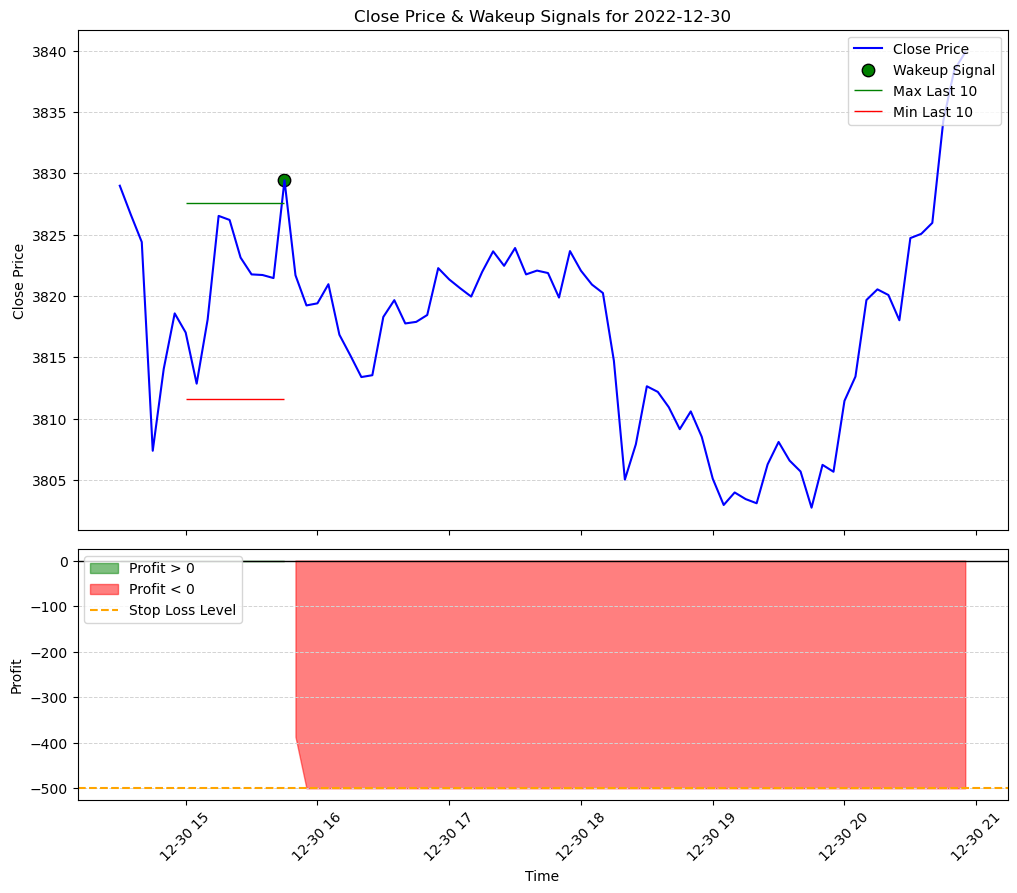

In [11]:
chart_path = plot_wakeup_signals(df, '2022-12-30')

In [12]:
# Extraer fechas únicas
df['date'] = pd.to_datetime(df['date'])
unique_dates = df['date'].dt.date.unique()
formatted_dates = [date.strftime('%Y-%m-%d') for date in unique_dates]
#print(formatted_dates)

In [ ]:
# iteración sobre todos los días disponibles
for date in formatted_dates:
    chart_path, summary_df = plot_wakeup_signals(df, date, summary_df)    

# Display the final summary_df after all calls
print("\nFinal Summary DataFrame:")
#summary_df

El beneficio al final del día 2022-12-29 en índice 77 es: 184.0 $
Min Profit of the day: -256.0 $
Max Profit of the day: 581.5 $
Chart saved successfully: Chart\wakeup_signals_2022-12-29.png
El beneficio al final del día 2022-12-30 en índice 155 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2022-12-30.png
El beneficio al final del día 2023-01-03 en índice 233 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 745.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-03.png
El beneficio al final del día 2023-01-04 en índice 311 es: 400.0 $
Min Profit of the day: -172.5 $
Max Profit of the day: 1391.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-04.png
El beneficio al final del día 2023-01-05 en índice 389 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 292.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-05.png
El beneficio al final del día 2023-01-0

El beneficio al final del día 2023-03-03 en índice 3431 es: 1407.5 $
Min Profit of the day: -290.0 $
Max Profit of the day: 1545.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-03.png
El beneficio al final del día 2023-03-06 en índice 3509 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 30.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-06.png
El beneficio al final del día 2023-03-07 en índice 3587 es: 1055.0 $
Min Profit of the day: -403.5 $
Max Profit of the day: 1326.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-07.png
El beneficio al final del día 2023-03-08 en índice 3665 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-08.png
El beneficio al final del día 2023-03-09 en índice 3743 es: 3806.5 $
Min Profit of the day: -162.5 $
Max Profit of the day: 4032.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-09.png
El beneficio al final del día 

El beneficio al final del día 2023-05-04 en índice 6785 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-05-04.png
El beneficio al final del día 2023-05-05 en índice 6863 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-05-05.png
El beneficio al final del día 2023-05-08 en índice 6941 es: 80.5 $
Min Profit of the day: -421.0 $
Max Profit of the day: 252.5 $
Chart saved successfully: Chart\wakeup_signals_2023-05-08.png
El beneficio al final del día 2023-05-09 en índice 7019 es: -358.0 $
Min Profit of the day: -391.0 $
Max Profit of the day: 140.5 $
Chart saved successfully: Chart\wakeup_signals_2023-05-09.png
El beneficio al final del día 2023-05-10 en índice 7097 es: -500.0 $
Min Profit of the day: -500.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-05-10.png
El beneficio al final del día 2023-05-

In [ ]:
# Ensure 'profit' column is numeric
summary_df["profit"] = pd.to_numeric(summary_df["profit"], errors='coerce')

# Compute cumulative profit by adding current 'profit' to previous 'cumprofit'
summary_df["cumprofit"] = summary_df["profit"]

# Iterate through rows starting from the second row to add previous cumprofit value
for i in range(1, len(summary_df)):
    summary_df.loc[i, "cumprofit"] += summary_df.loc[i - 1, "cumprofit"]

In [ ]:
summary_df = summary_df.round(2)
summary_df

In [ ]:
# Define the file path
csv_file_path = "summary_df.csv"  # You can change the filename if needed

# Save to CSV
summary_df.to_csv(csv_file_path, index=False)
print(f"Summary DataFrame saved successfully as {csv_file_path}")

In [ ]:
# Calcular profit total
total_profit = summary_df["profit"].sum()
formatted_profit_T = "{:,.2f}".format(total_profit).replace(",", "X").replace(".", ",").replace("X", ".")

print(f'El beneficio total del sistema durante 2022-2023-2024-2025 es de: {formatted_profit_T} €')
# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(summary_df.index, summary_df["cumprofit"], where=(summary_df["cumprofit"] >= 0), color="green", alpha=0.6)
ax.fill_between(summary_df.index, summary_df["cumprofit"], where=(summary_df["cumprofit"] < 0), color="red", alpha=0.6)

# Configuración
ax.axhline(0, color="black", linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Profit")
ax.set_title(f"Beneficio al final de todos los años: {formatted_profit_T} $")
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [ ]:
# Define the file path
csv_file_path = "summary_df_stop_600.csv"  # You can change the filename if needed

# Save to CSV
summary_df.to_csv(csv_file_path, index=False)
print(f"Summary DataFrame saved successfully as {csv_file_path}")

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["profit"], bins=40, edgecolor="black", alpha=0.7,color='orange')
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Histogram of Profit Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["min_profit"], bins=40, edgecolor="black", alpha=0.7,color='red')
plt.xlabel("Lost")
plt.ylabel("Frequency")
plt.title("Histogram of min_profit  Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["max_profit"], bins=40, edgecolor="black", alpha=0.7,color='green')
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Histogram of max_profit  Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()